In [61]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

In [28]:
def processing_image(img, func, **kwargs):
    """
    Hàm xử lý ảnh xám và ảnh màu\n
    Hàm này sẽ kiểm tra ảnh đầu vào là ảnh xám hay ảnh màu.\n
    Nếu là ảnh xám, hàm sẽ áp dụng trực tiếp hàm xử lý ảnh\n
    Nếu là ảnh màu, hàm sẽ tách các kênh màu, áp dụng hàm xử lý ảnh cho từng kênh, sau đó ghép các kênh lại với nhau.
    :param img: ảnh đầu vào (ảnh xám hoặc ảnh màu)
    :param func: hảm xử lý ảnh
    :param kwargs: các tham số của hàm xử lý ảnh
    :return: ảnh được xử lý


    """
    if img.shape[2] == 1:
        return func(img, **kwargs)
    elif img.shape[2] == 3:
        b, g, r = cv2.split(img)
        b = func(b, **kwargs)
        g = func(g, **kwargs)
        r = func(r, **kwargs)
        return cv2.merge([b, g, r])

In [29]:
def correlation(img, kernel):
    """
    Hàm tương quan\n
    Hàm này sẽ áp dụng kernel cho từng pixel của ảnh bằng cách lấy tích chập giữa kernel và vùng lân cận của pixel đó.\n
    Để xử lý biên, ta sẽ pad ảnh với giá trị 0 (zero-padding)\n
    Sau khi áp dụng kernel, ta sẽ clip giá trị pixel về khoảng [0, 255] và chuyển về kiểu uint8
    :param img: ảnh đầu vào
    :param kernel: kernel áp dụng (ma trận vuông có kích thước lẻ)
    :return: ảnh sau khi áp dụng kernel

    """
    ksize = kernel.shape[0]
    pad = ksize // 2
    padded = np.pad(img, pad, mode='constant')
    h, w = img.shape
    out = np.zeros_like(img,dtype=np.float32)
    for i in range(h):
        for j in range(w):
            region = padded[i:i+ksize, j:j+ksize]
            out[i, j] = np.sum(region * kernel)
    out = np.clip(out, 0, 255)
    return out.astype(np.uint8)

In [30]:
def convolution(img, kernel):
    """
    Hàm tích chập\n
    Ở hàm này, ta sẽ lật kernel theo cả hai chiều trước khi áp dụng hàm tương quan
    :param img: ảnh đầu vào
    :param kernel: kernel áp dụng (ma trận vuông có kích thước lẻ)
    :return: ảnh sau khi áp dụng kernel

    """
    return correlation(img,kernel[::-1,::-1])


# Bài 1: So sánh và phân tích các bộ lọc làm mờ

### Cài đặt các bộ lọc

In [31]:
def mean_filter(img, ksize=3):
    """
    Bộ lọc làm mờ trong bình\n
    Ở hàm này, ta sẽ tạo kernel là ma trận toàn 1 chia cho kích thước kernel bình phương\n
    Sau đó áp dụng hàm tương quan với kernel này
    :param img: ảnh đầu vào
    :param ksize: kích thước kernel (phải là số lẻ)
    :return: ảnh sau khi áp dụng bộ lọc

    """
    kernel = np.ones((ksize, ksize), dtype=np.float32) / (ksize * ksize)
    return correlation(img, kernel)


In [32]:
def gaussian_2d(ksize, sigma):
    """
    Hàm tạo kernel Gaussian 2D\n
    Ở hàm này, ta sẽ tạo ma trận 2D với công thức Gaussian\n
    Sau đó chuẩn hóa kernel để tổng các giá trị bằng 1
    :param ksize: kích thước kernel (phải là số lẻ)
    :param sigma: độ lệch chuẩn
    :return: kernel Gaussian 2D

    """
    ax = np.arange(-ksize // 2 + 1., ksize // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    return kernel / np.sum(kernel)

def gaussian_filter(img, ksize=None, sigma=1.0):
    """
    Bộ lọc làm mờ Gaussian\n
    Ở hàm này, ta sẽ tạo kernel Gaussian 2D bằng hàm gaussian\n
    Sau đó áp dụng hàm tương quan với kernel này
    :param img: ảnh đầu vào
    :param ksize: kích thước kernel (nếu None, sẽ tính toán dựa trên sigma)
    :param sigma: sigma của Gaussian, thường lấy giá trị từ 0.1 đến 10 càng lớn thì ảnh càng mờ
    :return: ảnh sau khi áp dụng bộ lọc


    """
    if ksize is None:
        ksize = int(2 * np.ceil(3 * sigma) + 1)
    kernel = gaussian_2d(ksize, sigma)
    return correlation(img, kernel)






In [85]:
def median_filter(img, ksize=3):
    """
    Bộ lọc làm mờ trung vị\n
    Ở hàm này, ta sẽ áp dụng bộ lọc trung vị bằng cách lấy giá trị trung vị trong vùng lân cận của mỗi pixel\n
    Để lấy trung vị, đầu tiên phải sắp xếp các giá trị trong vùng lân cận\n
    Tiếp theo, lấy giá trị ở giữa danh sách đã sắp xếp làm giá trị trung vị\n
    Áp dụng hàm này cho từng pixel trong ảnh
    :param img: ảnh đầu vào
    :param ksize: kích thước kernel
    :return: ảnh sau khi áp dụng bộ lọc

    """

    pad = ksize//2
    padded = np.pad(img,pad, mode='constant')
    h,w = img.shape
    out = np.zeros_like(img,dtype=np.float32)
    for i in range(h):
        for j in range(w):
            region = padded[i:i+ksize, j:j+ksize]
            out[i,j] = np.median(region)
    out = np.clip(out, 0, 255)
    return out.astype(np.uint8)

In [34]:
def bilateral_filter(img, ksize=5, sigma_color=75, sigma_space=75):
    """
    Bộ lọc làm mờ song phương\n
    Ở hàm này, ta sẽ áp dụng bộ lọc song phương bằng cách kết hợp hai yếu tố: khoảng cách không gian và khoảng cách màu sắc\n
    Để tính toán trọng số cho mỗi pixel trong vùng lân cận, ta sẽ sử dụng công thức Gaussian cho cả hai yếu tố trên\n
    Trọng số tổng hợp sẽ là tích của hai trọng số này\n
    Áp dụng hàm này cho từng pixel trong ảnh
    :param img: ảnh đầu vào
    :param ksize: kích thước kernel
    :param sigma_color: độ lệch chuẩn về màu sắc
    :param sigma_space: độ lệch chuẩn về không gian
    :return: ảnh sau khi áp dụng bộ lọc

    """
    pad = ksize // 2
    padded = np.pad(img, pad, mode='constant')
    h, w = img.shape
    out = np.zeros_like(img, dtype=np.float32)

    ax = np.arange(-pad, pad + 1)
    xx, yy = np.meshgrid(ax, ax)
    spatial_kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma_space**2))

    for i in range(h):
        for j in range(w):
            region = padded[i:i + ksize, j:j + ksize]
            color_diff = region - img[i, j]
            color_kernel = np.exp(-(color_diff**2) / (2. * sigma_color**2))
            combined_kernel = spatial_kernel * color_kernel
            combined_kernel /= np.sum(combined_kernel)
            out[i, j] = np.sum(region * combined_kernel)

    out = np.clip(out, 0, 255)
    return out.astype(np.uint8)

### Thử nghiệm các bộ lọc

In [35]:
def gaussian_noise(img, mean=0, sigma=25):
    """
    Hàm thêm nhiễu Gaussian vào ảnh\n
    Ở hàm này, ta sẽ tạo ma trận nhiễu Gaussian với cùng kích thước ảnh\n
    Sau đó cộng ma trận nhiễu này vào ảnh gốc\n
    Cuối cùng, ta sẽ clip giá trị pixel về khoảng [0, 255] và chuyển về kiểu uint8
    :param img: ảnh đầu vào
    :param mean: giá trị trung bình của nhiễu
    :param sigma: độ lệch chuẩn của nhiễu
    :return: ảnh sau khi thêm nhiễu

    """
    noise = np.random.normal(mean, sigma, img.shape).astype(np.float32)
    noisy_img = img.astype(np.float32) + noise
    noisy_img = np.clip(noisy_img, 0, 255)
    return noisy_img.astype(np.uint8)

In [36]:
def salt_and_pepper_noise(img, prob=0.01):
    """
    Hàm thêm nhiễu muối và tiêu vào ảnh\n
    Ở hàm này, ta sẽ tạo ma trận nhiễu với cùng kích thước ảnh\n
    Mỗi pixel trong ma trận nhiễu sẽ có xác suất prob để trở thành 0 (tiêu) hoặc 255 (muối)\n
    Sau đó, ta sẽ thay đổi giá trị pixel tương ứng trong ảnh gốc\n
    :param img: ảnh đầu vào
    :param prob: xác suất để một pixel bị nhiễu muối hoặc tiêu
    :return: ảnh sau khi thêm nhiễu

    """
    noisy_img = img.copy()
    rnd = np.random.rand(*img.shape)
    noisy_img[rnd < prob / 2] = 0
    noisy_img[rnd > 1 - prob / 2] = 255
    return noisy_img

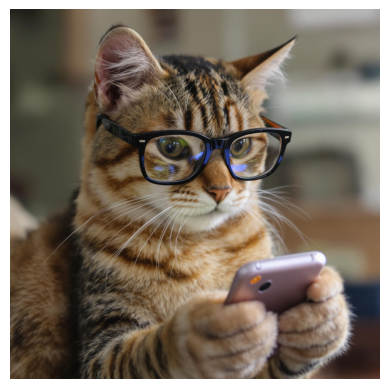

In [76]:
img = cv2.imread('../img/cat.jpeg')
plt.imshow(img[:,:,::-1])
plt.axis('off')
plt.show()

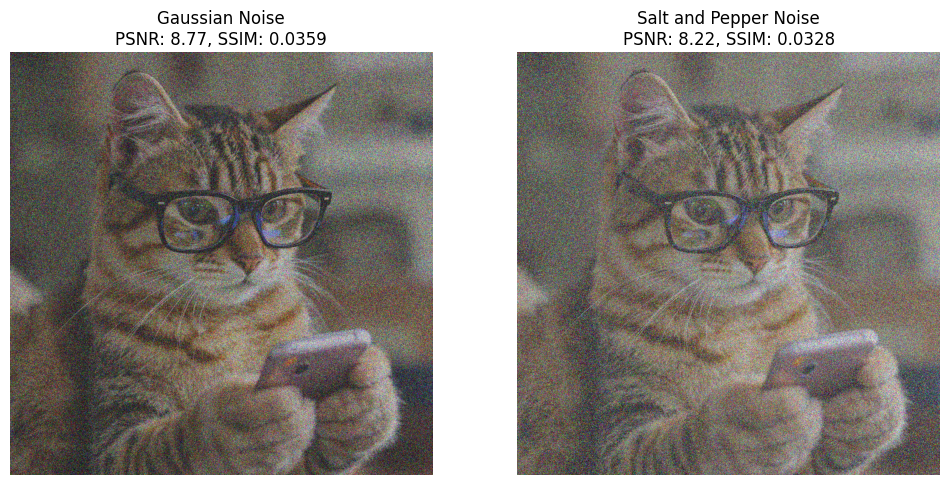

In [81]:
gauss_noise = processing_image(img, gaussian_noise, mean=-30, sigma=150)
gauss_PSNR = cv2.PSNR(img, gauss_noise)
gauss_SSIM = ssim(img, gauss_noise, win_size=3)

salt_pepper_noise = processing_image(img, salt_and_pepper_noise, prob=0.5)
salt_pepper_PSNR = cv2.PSNR(img, salt_pepper_noise)
salt_pepper_SSIM= ssim(img, salt_pepper_noise, win_size=3)


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title(f'Gaussian Noise\nPSNR: {gauss_PSNR:.2f}, SSIM: {gauss_SSIM:.4f}')
plt.imshow(gauss_noise[:, :, ::-1])
plt.axis('off')


plt.subplot(1, 2, 2)
plt.title(f'Salt and Pepper Noise\nPSNR: {salt_pepper_PSNR:.2f}, SSIM: {salt_pepper_SSIM:.4f}')
plt.imshow(salt_pepper_noise[:, :, ::-1])
plt.axis('off')


plt.show()

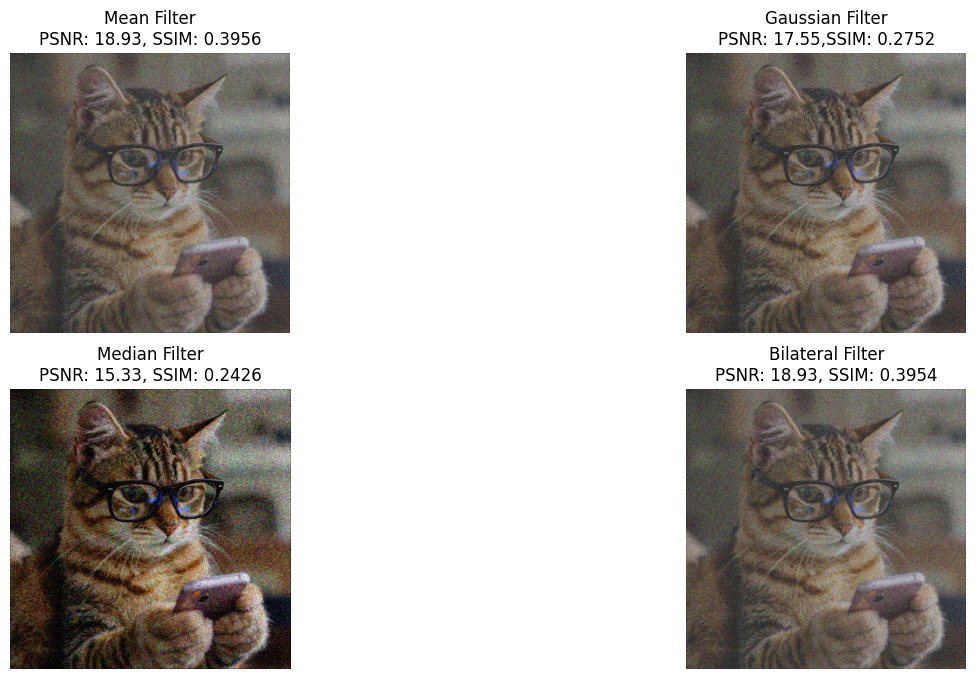

In [94]:
mean = processing_image(gauss_noise, mean_filter, ksize=5)
mean_PSNR = cv2.PSNR(img, mean)
mean_SSIM = ssim(img, mean, win_size=3)

gaussian = processing_image(gauss_noise, gaussian_filter, sigma=1.0)
gaussian_PSNR = cv2.PSNR(img, gaussian)
gaussian_SSIM = ssim(img, gaussian, win_size=3)

median = processing_image(gauss_noise, median_filter, ksize=5)
median_PSNR = cv2.PSNR(img, median)
median_SSIM= ssim(img, median, win_size=3)

bilateral = processing_image(gauss_noise, bilateral_filter, ksize=5, sigma_color=75, sigma_space=75)
bilateral_PSNR = cv2.PSNR(img, bilateral)
bilateral_SSIM = ssim(img, bilateral, win_size=3)


plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.title(f'Mean Filter\nPSNR: {mean_PSNR:.2f}, SSIM: {mean_SSIM:.4f}')
plt.imshow(mean[:, :, ::-1])
plt.axis('off')


plt.subplot(2, 2, 2)
plt.title(f'Gaussian Filter\nPSNR: {gaussian_PSNR:.2f},SSIM: {gaussian_SSIM:.4f}')
plt.imshow(gaussian[:, :, ::-1])
plt.axis('off')


plt.subplot(2, 2, 3)
plt.title(f'Median Filter\nPSNR: {median_PSNR:.2f}, SSIM: {median_SSIM:.4f}')
plt.imshow(median[:, :, ::-1])
plt.axis('off')


plt.subplot(2, 2, 4)
plt.title(f'Bilateral Filter\nPSNR: {bilateral_PSNR:.2f}, SSIM: {bilateral_SSIM:.4f}')
plt.imshow(bilateral[:, :, ::-1])
plt.axis('off')

plt.show()



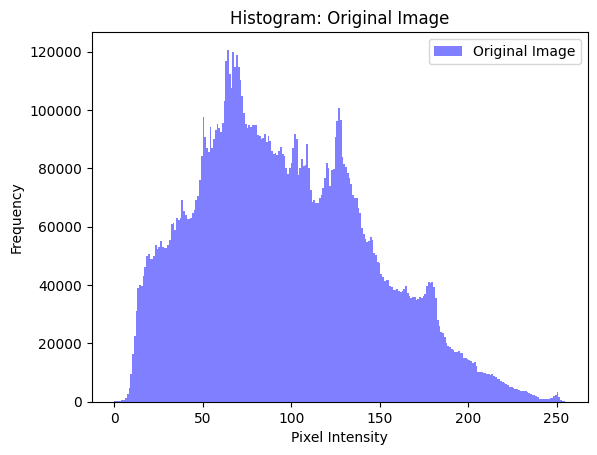

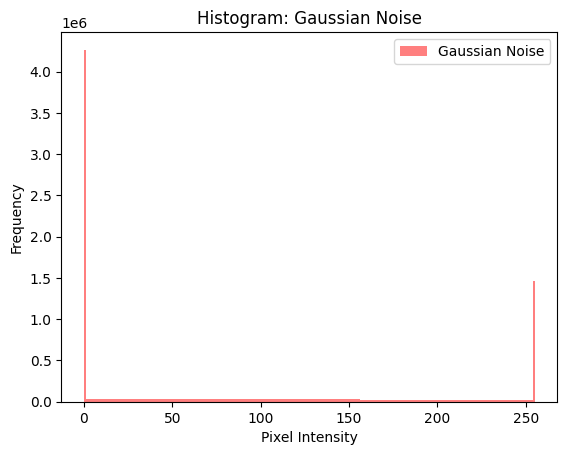

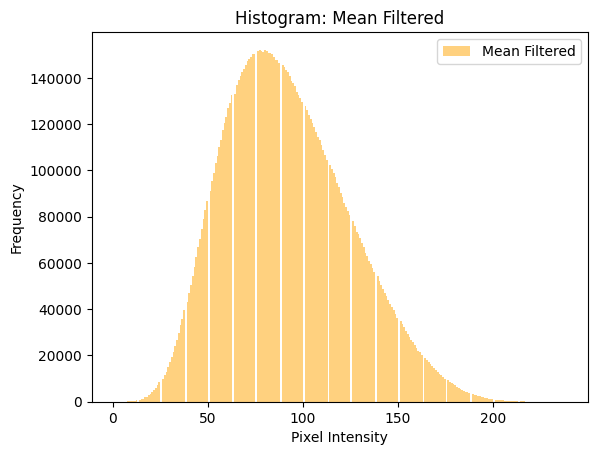

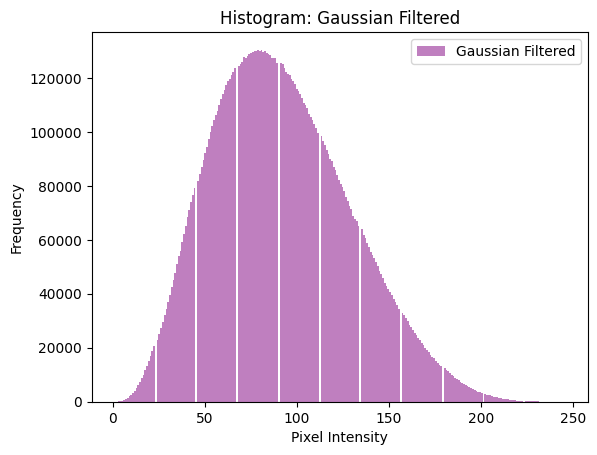

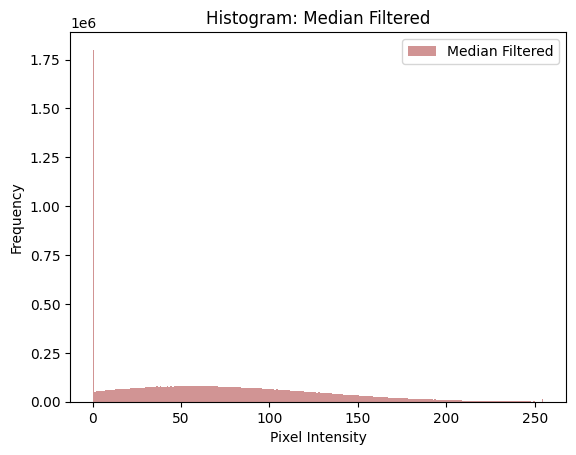

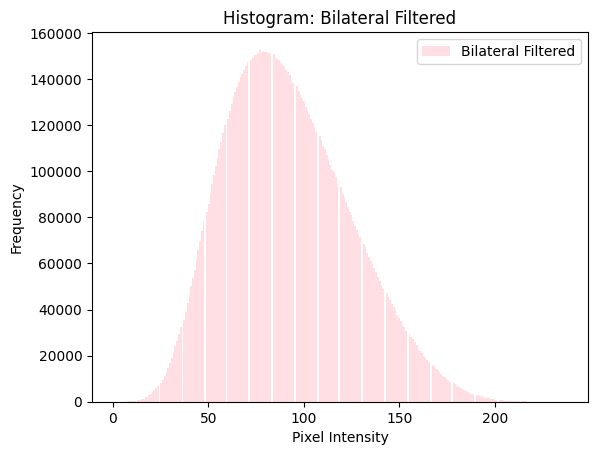

In [95]:
hist_data = [
    (img.ravel(), 'blue', 'Original Image'),
    (gauss_noise.ravel(), 'red', 'Gaussian Noise'),
    (mean.ravel(), 'orange', 'Mean Filtered'),
    (gaussian.ravel(), 'purple', 'Gaussian Filtered'),
    (median.ravel(), 'brown', 'Median Filtered'),
    (bilateral.ravel(), 'pink', 'Bilateral Filtered')
]

for data, color, label in hist_data:
    plt.figure()
    plt.hist(data, bins=256, color=color, alpha=0.5, label=label)
    plt.title(f'Histogram: {label}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

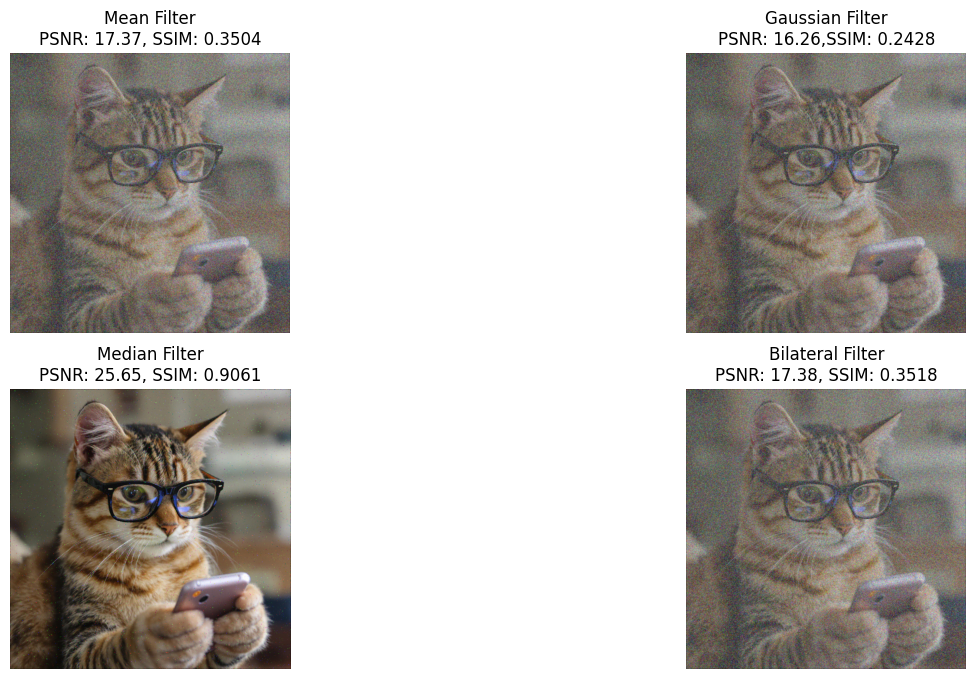

In [91]:
mean = processing_image(salt_pepper_noise, mean_filter, ksize=5)
mean_PSNR = cv2.PSNR(img, mean)
mean_SSIM = ssim(img, mean, win_size=3)

gaussian = processing_image(salt_pepper_noise, gaussian_filter, sigma=1.0)
gaussian_PSNR = cv2.PSNR(img, gaussian)
gaussian_SSIM = ssim(img, gaussian, win_size=3)

median = processing_image(salt_pepper_noise, median_filter, ksize=5)
median_PSNR = cv2.PSNR(img, median)
median_SSIM= ssim(img, median, win_size=3)

bilateral = processing_image(salt_pepper_noise, bilateral_filter, ksize=5, sigma_color=75, sigma_space=75)
bilateral_PSNR = cv2.PSNR(img, bilateral)
bilateral_SSIM = ssim(img, bilateral, win_size=3)

plt.figure(figsize=(16, 8))


plt.subplot(2, 2, 1)
plt.title(f'Mean Filter\nPSNR: {mean_PSNR:.2f}, SSIM: {mean_SSIM:.4f}')
plt.imshow(mean[:, :, ::-1])
plt.axis('off')


plt.subplot(2, 2, 2)
plt.title(f'Gaussian Filter\nPSNR: {gaussian_PSNR:.2f},SSIM: {gaussian_SSIM:.4f}')
plt.imshow(gaussian[:, :, ::-1])
plt.axis('off')


plt.subplot(2, 2, 3)
plt.title(f'Median Filter\nPSNR: {median_PSNR:.2f}, SSIM: {median_SSIM:.4f}')
plt.imshow(median[:, :, ::-1])
plt.axis('off')


plt.subplot(2, 2, 4)
plt.title(f'Bilateral Filter\nPSNR: {bilateral_PSNR:.2f}, SSIM: {bilateral_SSIM:.4f}')
plt.imshow(bilateral[:, :, ::-1])
plt.axis('off')

plt.show()

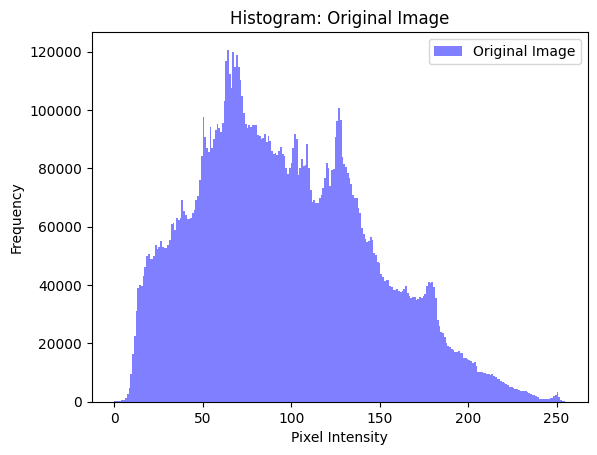

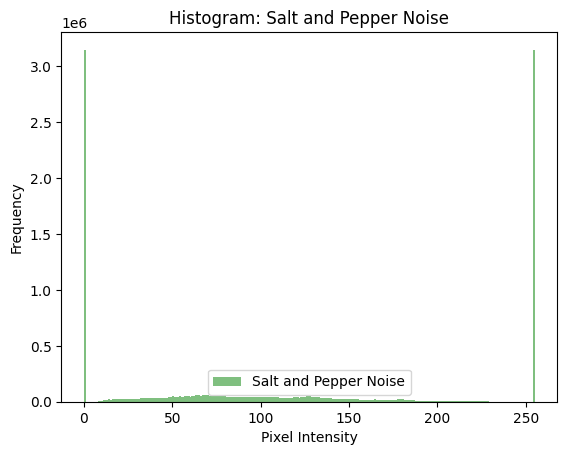

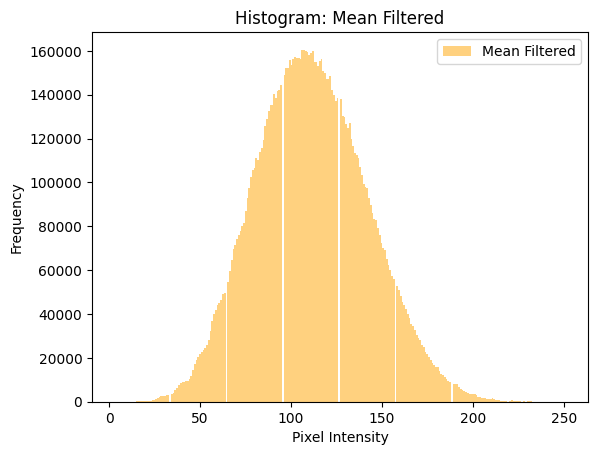

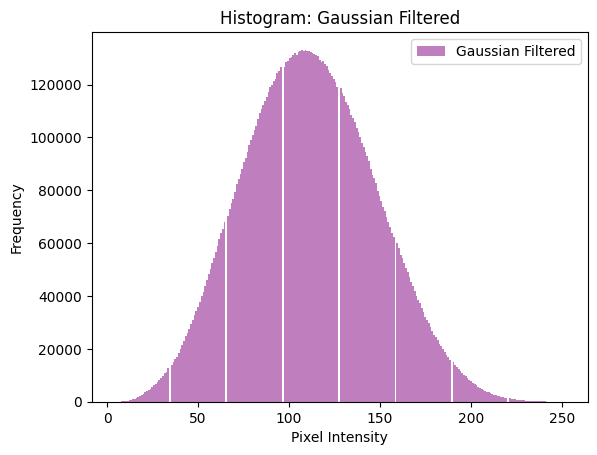

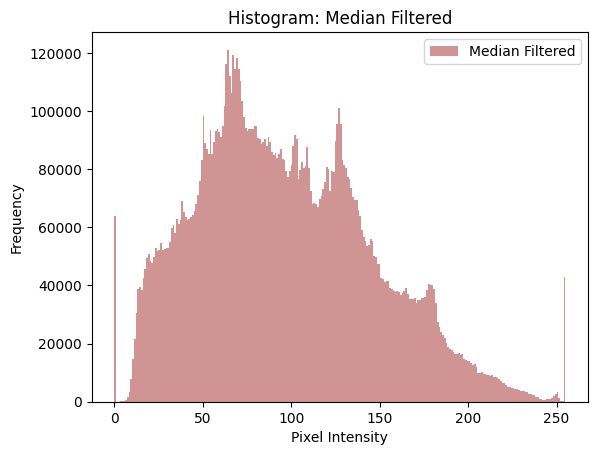

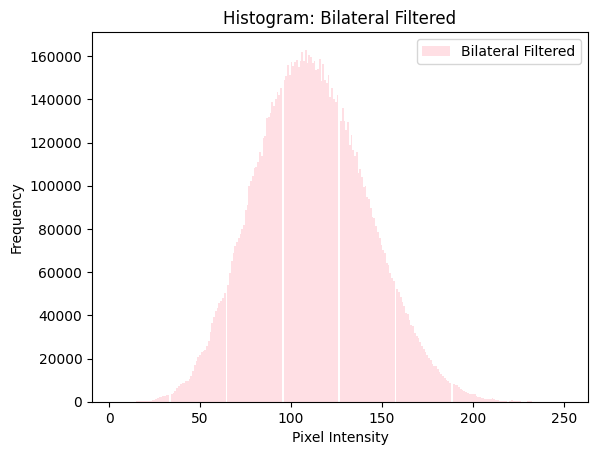

In [93]:
hist_data = [
    (img.ravel(), 'blue', 'Original Image'),
    (salt_pepper_noise.ravel(), 'green', 'Salt and Pepper Noise'),
    (mean.ravel(), 'orange', 'Mean Filtered'),
    (gaussian.ravel(), 'purple', 'Gaussian Filtered'),
    (median.ravel(), 'brown', 'Median Filtered'),
    (bilateral.ravel(), 'pink', 'Bilateral Filtered')
]

for data, color, label in hist_data:
    plt.figure()
    plt.hist(data, bins=256, color=color, alpha=0.5, label=label)
    plt.title(f'Histogram: {label}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Bài 2: Edge Detection

Yêu cầu:
1. Cài đặt Sobel, Prewitt, Laplacian từ đầu (không dùng hàm cv2 có sẵn).
2. So sánh kết quả với bộ lọc Canny.
3. Ứng dụng pipeline vào ảnh thực tế (ảnh đường phố, ảnh văn bản).


 Kết quả mong đợi:

o Bộ ảnh minh họa các bước (gradient X, Y, magnitude, threshold).

o Đánh giá độ nhạy của tham số ngưỡng.

In [ ]:
def sobel_filter(img):
    """
    Bộ lọc Sobel\n
    Ở hàm này, ta sẽ tạo hai kernel Sobel cho hướng X và Y\n
    Sau đó áp dụng hàm tích chập với từng kernel để lấy gradient theo hai hướng\n
    Cuối cùng, ta sẽ tính magnitude của gradient và chuyển về kiểu uint8
    :param img: ảnh đầu vào (ảnh xám)
    :return: ảnh sau khi áp dụng bộ lọc Sobel

    """
    sobel_x = np.array([[ -1, 0, 1],
                        [ -2, 0, 2],
                        [ -1, 0, 1]], dtype=np.float32)

    sobel_y = np.array([[ 1,  2,  1],
                        [ 0,  0,  0],
                        [-1, -2, -1]], dtype=np.float32)

    grad_x = convolution(img, sobel_x)
    grad_y = convolution(img, sobel_y)

    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    magnitude = np.clip(magnitude, 0, 255)
    return magnitude.astype(np.uint8), grad_x, grad_y

In [ ]:
def prewitt_filter(img):
    """
    Bộ lọc Prewitt
    Tương tự Sobel nhưng sử dụng kernel Prewitt
    """
    prewitt_x = np.array([[-1, 0, 1],
                          [-1, 0, 1],
                          [-1, 0, 1]], dtype=np.float32)

    prewitt_y = np.array([[ 1,  1,  1],
                          [ 0,  0,  0],
                          [-1, -1, -1]], dtype=np.float32)

    grad_x = convolution(img, prewitt_x)
    grad_y = convolution(img, prewitt_y)

    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    magnitude = np.clip(magnitude, 0, 255)
    return magnitude.astype(np.uint8), grad_x, grad_y

In [ ]:
def laplacian_filter(img):
    """
    Bộ lọc Laplacian
    Sử dụng kernel Laplacian 3x3 để phát hiện biên
    """
    laplacian_kernel = np.array([[0, -1, 0],
                                [-1, 4, -1],
                                [0, -1, 0]], dtype=np.float32)

    result = convolution(img, laplacian_kernel)
    result = np.clip(np.abs(result), 0, 255)
    return result.astype(np.uint8)

In [ ]:
def apply_threshold(img, threshold):
    """
    Áp dụng ngưỡng để tạo ảnh nhị phân
    """
    binary = np.zeros_like(img)
    binary[img >= threshold] = 255
    return binary

In [ ]:
def edge_detection_comparison(img_path):
    """
    So sánh các phương pháp phát hiện biên
    """
    # Load và chuyển đổi ảnh
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Áp dụng các bộ lọc
    sobel_mag, sobel_x, sobel_y = sobel_filter(gray)
    prewitt_mag, prewitt_x, prewitt_y = prewitt_filter(gray)
    laplacian = laplacian_filter(gray)

    # Canny edge detection để so sánh
    canny = cv2.Canny(gray, 50, 150)

    # Hiển thị kết quả Sobel chi tiết
    plt.figure(figsize=(20, 12))

    # Sobel gradients
    plt.subplot(3, 4, 1)
    plt.imshow(gray, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(3, 4, 2)
    plt.imshow(sobel_x, cmap='gray')
    plt.title('Sobel Gradient X')
    plt.axis('off')

    plt.subplot(3, 4, 3)
    plt.imshow(sobel_y, cmap='gray')
    plt.title('Sobel Gradient Y')
    plt.axis('off')

    plt.subplot(3, 4, 4)
    plt.imshow(sobel_mag, cmap='gray')
    plt.title('Sobel Magnitude')
    plt.axis('off')

    # Prewitt gradients
    plt.subplot(3, 4, 5)
    plt.imshow(prewitt_x, cmap='gray')
    plt.title('Prewitt Gradient X')
    plt.axis('off')

    plt.subplot(3, 4, 6)
    plt.imshow(prewitt_y, cmap='gray')
    plt.title('Prewitt Gradient Y')
    plt.axis('off')

    plt.subplot(3, 4, 7)
    plt.imshow(prewitt_mag, cmap='gray')
    plt.title('Prewitt Magnitude')
    plt.axis('off')

    plt.subplot(3, 4, 8)
    plt.imshow(laplacian, cmap='gray')
    plt.title('Laplacian')
    plt.axis('off')

    # Comparison with Canny
    plt.subplot(3, 4, 9)
    plt.imshow(apply_threshold(sobel_mag, 50), cmap='gray')
    plt.title('Sobel (Threshold=50)')
    plt.axis('off')

    plt.subplot(3, 4, 10)
    plt.imshow(apply_threshold(prewitt_mag, 50), cmap='gray')
    plt.title('Prewitt (Threshold=50)')
    plt.axis('off')

    plt.subplot(3, 4, 11)
    plt.imshow(apply_threshold(laplacian, 30), cmap='gray')
    plt.title('Laplacian (Threshold=30)')
    plt.axis('off')

    plt.subplot(3, 4, 12)
    plt.imshow(canny, cmap='gray')
    plt.title('Canny Edge Detection')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return sobel_mag, prewitt_mag, laplacian, canny

In [ ]:
def threshold_sensitivity_analysis(img_path):
    """
    Đánh giá độ nhạy của tham số ngưỡng
    """
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    sobel_mag, _, _ = sobel_filter(gray)

    thresholds = [20, 50, 80, 120, 160, 200]

    plt.figure(figsize=(18, 6))

    plt.subplot(2, 7, 1)
    plt.imshow(gray, cmap='gray')
    plt.title('Original')
    plt.axis('off')

    plt.subplot(2, 7, 8)
    plt.imshow(sobel_mag, cmap='gray')
    plt.title('Sobel Magnitude')
    plt.axis('off')

    for i, threshold in enumerate(thresholds):
        binary = apply_threshold(sobel_mag, threshold)
        plt.subplot(2, 7, i + 2)
        plt.imshow(binary, cmap='gray')
        plt.title(f'Threshold={threshold}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# Test với ảnh cat
edge_detection_comparison('../img/cat.jpeg')

In [ ]:
# Phân tích độ nhạy ngưỡng
threshold_sensitivity_analysis('../img/cat.jpeg')

In [ ]:
def edge_detection_pipeline(img_path, method='sobel', threshold=50):
    """
    Pipeline hoàn chỉnh cho phát hiện biên
    """
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Áp dụng Gaussian blur để giảm nhiễu
    blurred = gaussian_filter(gray, sigma=1.0)

    if method == 'sobel':
        edges, _, _ = sobel_filter(blurred)
    elif method == 'prewitt':
        edges, _, _ = prewitt_filter(blurred)
    elif method == 'laplacian':
        edges = laplacian_filter(blurred)
    else:
        edges = cv2.Canny(blurred, 50, 150)

    # Áp dụng ngưỡng
    binary_edges = apply_threshold(edges, threshold)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 4, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(blurred, cmap='gray')
    plt.title('Gaussian Blurred')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(edges, cmap='gray')
    plt.title(f'{method.capitalize()} Edges')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(binary_edges, cmap='gray')
    plt.title(f'Binary Edges (T={threshold})')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return binary_edges

In [ ]:
# Test pipeline với các phương pháp khác nhau
methods = ['sobel', 'prewitt', 'laplacian', 'canny']
for method in methods:
    print(f"\n--- {method.upper()} METHOD ---")
    edge_detection_pipeline('../img/cat.jpeg', method=method, threshold=50)

# Bài 3: Tăng cường ảnh